**Preprocessing IR Image**

In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import torch
from torchvision import transforms

class IRImageProcessor:
    """
    Image processor for infrared sky images following the paper methodology:
    1. Normalization
    2. Bicubic interpolation for upscaling
    3. OpenCV colormap (JET) application
    """

    def __init__(self, target_size=(240, 320), colormap=cv2.COLORMAP_JET):
        self.target_size = target_size
        self.colormap = colormap

    def process_single_image(self, ir_image_path):
        """Process a single IR image following paper methodology"""
        # Read IR image (16-bit depth preserved)
        ir_image = cv2.imread(ir_image_path, cv2.IMREAD_ANYDEPTH)

        # Step 1: Normalization to 0-255 range
        img_normalized = cv2.normalize(ir_image, None, 0, 255, cv2.NORM_MINMAX)

        # Step 2: Bicubic interpolation for upscaling
        img_upscaled = cv2.resize(
            img_normalized,
            self.target_size,
            interpolation=cv2.INTER_CUBIC
        )

        # Step 3: Apply OpenCV colormap (convert to RGB)
        img_colored = cv2.applyColorMap(
            img_upscaled.astype(np.uint8),
            self.colormap
        )

        # Convert BGR to RGB for proper processing
        img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

        return img_rgb

    def process_batch_images(self, input_dir, output_dir):
        """Process all images in a directory"""
        os.makedirs(output_dir, exist_ok=True)

        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for img_file in tqdm(image_files, desc="Processing IR images"):
            img_path = os.path.join(input_dir, img_file)
            processed_img = self.process_single_image(img_path)

            output_path = os.path.join(output_dir, img_file)
            # Save as RGB
            cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

    def get_tensor_transform(self):
        """Get PyTorch transform for processed images"""
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

def preprocess_for_training(input_dir, output_dir, target_size=(240, 320)):
    """Main preprocessing function for training data"""
    processor = IRImageProcessor(target_size)
    processor.process_batch_images(input_dir, output_dir)
    print(f"Preprocessing complete. Processed images saved to {output_dir}")

def preprocess_multiple_days(input_dirs, output_base_dir, target_size=(240, 320)):
    """Preprocess IR images from multiple days"""
    for input_dir in input_dirs:
        date_folder = os.path.basename(os.path.dirname(input_dir.rstrip('/\\')))
        output_dir = os.path.join(output_base_dir, date_folder)
        preprocess_for_training(input_dir, output_dir, target_size)

if __name__ == '__main__':
    # Example usage for multiple days
    input_dirs = [
        '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/infrared',
    ]
    preprocess_multiple_days(
        input_dirs=input_dirs,
        output_base_dir='data/processed'
    )

Processing IR images: 100%|██████████| 1697/1697 [01:05<00:00, 26.04it/s]

Preprocessing complete. Processed images saved to data/processed/2019_01_18


**CNN Regression Model**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#CNN Regression model for solar irradiance nowcasting from IR sky images.
class SolarCNNRegression(nn.Module):


    def __init__(self, input_channels=3, num_classes=1):
        super(SolarCNNRegression, self).__init__()

        # Feature extraction layers (Convolutional backbone)
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 240x320 -> 120x160

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 120x160 -> 60x80

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 60x80 -> 30x40

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 30x40 -> 15x20

            # Fifth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )

        # Regression head for irradiance prediction
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)  # Output: solar irradiance value
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Extract features
        features = self.features(x)

        # Regression prediction
        irradiance = self.regressor(features)

        return irradiance

#Extract features for LSTM input
    def get_features(self, x):

        with torch.no_grad():
            features = self.features(x)
            return features.flatten(1)  # Flatten for sequence input


class SolarCNNWithFeatureExtraction(SolarCNNRegression):


    def __init__(self, input_channels=3, feature_dim=512):
        super().__init__(input_channels, 1)
        self.feature_dim = feature_dim

        # Feature projection layer for LSTM input
        self.feature_projector = nn.Sequential(
            nn.Linear(512, feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

    def forward(self, x, return_features=False):
        # Extract convolutional features
        conv_features = self.features(x)
        flattened_features = conv_features.flatten(1)

        # Get irradiance prediction
        irradiance = self.regressor[-3:](
            self.regressor[:-3](flattened_features)
        )

        if return_features:
            # Project features for LSTM input
            projected_features = self.feature_projector(flattened_features)
            return irradiance, projected_features

        return irradiance


# Legacy model for backward compatibility
class SolarCNN(SolarCNNRegression):

    pass

**Training**

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading multi-day dataset...
Train samples: 1357, Val samples: 340
Using device: cuda
Starting training for 5 epochs...
Model parameters: 1,997,569

Epoch 1/5


Training: 100%|██████████| 43/43 [00:06<00:00,  6.28it/s, Loss=1972.4851]


Train Loss: 2286.2582


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s, Val Loss=2024.1830]


Val Loss: 2232.3039, RMSE: 47.32 W/m², MAE: 45.11 W/m²
New best model saved! RMSE: 47.32 W/m²

Epoch 2/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:06<00:00,  6.57it/s, Loss=1235.0857]


Train Loss: 2036.3095


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, Val Loss=1544.7787]


Val Loss: 1664.5659, RMSE: 40.85 W/m², MAE: 38.62 W/m²
New best model saved! RMSE: 40.85 W/m²

Epoch 3/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:07<00:00,  5.94it/s, Loss=388.0947]


Train Loss: 1108.4612


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, Val Loss=494.2188]


Val Loss: 496.4197, RMSE: 22.28 W/m², MAE: 18.62 W/m²
New best model saved! RMSE: 22.28 W/m²

Epoch 4/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:09<00:00,  4.62it/s, Loss=74.7807]


Train Loss: 224.5496


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s, Val Loss=120.6759]


Val Loss: 124.4715, RMSE: 11.16 W/m², MAE: 8.50 W/m²
New best model saved! RMSE: 11.16 W/m²

Epoch 5/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:08<00:00,  4.88it/s, Loss=76.6704]


Train Loss: 126.4158


Validation: 100%|██████████| 11/11 [00:02<00:00,  5.47it/s, Val Loss=113.7739]


Val Loss: 143.6125, RMSE: 12.03 W/m², MAE: 9.75 W/m²
Training completed!


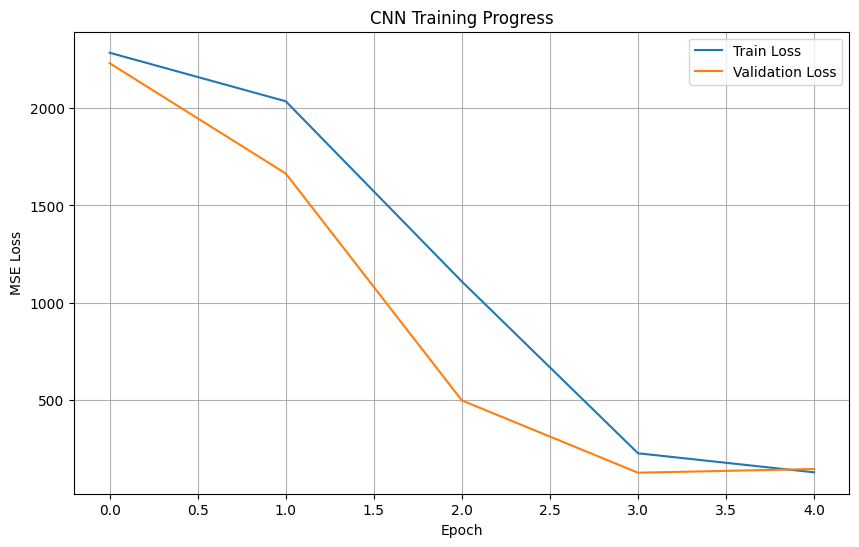

CNN nowcasting training completed!


In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json
import cv2  # Needed for image reading

class MultiDayDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, irradiance_values):
        self.image_paths = image_paths
        self.irradiance_values = irradiance_values
        self.image_processor = IRImageProcessor(target_size=(240, 320))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
            img = self.image_processor.process_single_image(img_path)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0
        irradiance = torch.tensor(self.irradiance_values[idx], dtype=torch.float32)
        return img_tensor, irradiance

def get_multi_day_dataset(image_dirs, irradiance_files):
    image_paths = []
    irradiance_values = []

    for img_dir, irr_file in zip(image_dirs, irradiance_files):
        # Load irradiance data
        if irr_file.endswith('.csv'):
            df = pd.read_csv(irr_file)
            values = df.iloc[:, 1].values.astype(np.float32)
        else:
            values = np.loadtxt(irr_file, delimiter=',')[:, 1].astype(np.float32)

        files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        files = files[:len(values)]  # Ensure matching length

        image_paths.extend([os.path.join(img_dir, f) for f in files])
        irradiance_values.extend(values[:len(files)])

    return MultiDayDataset(image_paths, irradiance_values)

class CNNTrainer:
    """
    Trainer class for CNN nowcasting model following paper methodology
    """

    def __init__(self, model_type='standard', config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Default configuration
        self.config = {
            'learning_rate': 1e-4,
            'batch_size': 32,
            'num_epochs': 5,
            'weight_decay': 1e-4,
            'scheduler_patience': 10,
            'early_stopping_patience': 15,
            'save_dir': 'models',
            'log_dir': 'logs'
        }

        if config:
            self.config.update(config)

        # Create directories
        os.makedirs(self.config['save_dir'], exist_ok=True)
        os.makedirs(self.config['log_dir'], exist_ok=True)

        # Initialize model
        self.model_type = model_type # Store model type
        if model_type == 'with_features':
            self.model = SolarCNNWithFeatureExtraction().to(self.device)
        else:
            self.model = SolarCNNRegression().to(self.device)

        # Initialize optimizer and scheduler
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.config['learning_rate'],
            weight_decay=self.config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.config['scheduler_patience'],
            factor=0.5,
        )

        self.criterion = nn.MSELoss()

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        with tqdm(train_loader, desc="Training") as pbar:
            for batch_idx, (images, targets) in enumerate(pbar):
                images, targets = images.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), targets)

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        predictions = []
        targets = []

        with torch.no_grad():
            with tqdm(val_loader, desc="Validation") as pbar:
                for images, batch_targets in pbar:
                    images, batch_targets = images.to(self.device), batch_targets.to(self.device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs.squeeze(), batch_targets)

                    total_loss += loss.item()

                    predictions.extend(outputs.squeeze().cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

                    pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(val_loader)

        # Calculate additional metrics
        predictions = np.array(predictions)
        targets = np.array(targets)

        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)

        return avg_loss, rmse, mae, predictions, targets

    def train(self, train_loader, val_loader=None):
        """Main training loop"""
        print(f"Starting training for {self.config['num_epochs']} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")

            # Training
            train_loss = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)

            print(f"Train Loss: {train_loss:.4f}")

            # Validation
            if val_loader is not None:
                val_loss, rmse, mae, predictions, targets = self.validate_epoch(val_loader)
                self.val_losses.append(val_loss)

                print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.2f} W/m², MAE: {mae:.2f} W/m²")

                # Learning rate scheduling
                self.scheduler.step(val_loss)

                # Early stopping and model saving
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0

                    # Save best model - check model_type
                    model_path = os.path.join(self.config['save_dir'], 'best_cnn_model.pth')
                    if self.model_type == 'with_features':
                         model_path = os.path.join(self.config['save_dir'], 'best_cnn_with_features_model.pth')

                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                        'config': self.config
                    }, model_path)


                    print(f"New best model saved! RMSE: {rmse:.2f} W/m²")
                else:
                    self.patience_counter += 1

                if self.patience_counter >= self.config['early_stopping_patience']:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save final model
        final_model_path = os.path.join(self.config['save_dir'], 'final_cnn_model.pth')
        if self.model_type == 'with_features':
            final_model_path = os.path.join(self.config['save_dir'], 'final_cnn_with_features_model.pth')

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, final_model_path)


        # Save training history
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': self.config
        }

        with open(os.path.join(self.config['log_dir'], 'cnn_training_history.json'), 'w') as f:
            json.dump(history, f, indent=2)

        print("Training completed!")
        return self.train_losses, self.val_losses

    def load_model(self, checkpoint_path):
        """Load a saved model"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        return checkpoint

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        targets = []

        with torch.no_grad():
            for images, batch_targets in tqdm(test_loader, desc="Evaluating"):
                images, batch_targets = images.to(self.device), batch_targets.to(self.device)

                outputs = self.model(images)
                predictions.extend(outputs.squeeze().cpu().numpy())
                targets.extend(batch_targets.cpu().numpy())

        predictions = np.array(predictions)
        targets = np.array(targets)

        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)

        print(f"Test Results - RMSE: {rmse:.2f} W/m², MAE: {mae:.2f} W/m²")

        return rmse, mae, predictions, targets

def train_cnn_nowcasting():
    """Main function to train CNN nowcasting model"""

    # Configuration
    config = {
        'learning_rate': 1e-4,
        'batch_size': 32,
        'num_epochs': 5,
        # List of days
        'image_dirs': [
            '/content/data/processed/2019_01_18'
        ],
        'irradiance_files': [
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv'
        ]
    }

    # Create multi-day dataset
    print("Loading multi-day dataset...")
    dataset = get_multi_day_dataset(config['image_dirs'], config['irradiance_files'])

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2
    )

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Initialize trainer
    trainer = CNNTrainer(model_type='with_features', config=config)


    # Train model
    train_losses, val_losses = trainer.train(train_loader, val_loader)

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('CNN Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig('logs/cnn_training_curves.png')
    plt.show()

    print("CNN nowcasting training completed!")

if __name__ == '__main__':
    train_cnn_nowcasting()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading multi-day dataset...
Train samples: 1357, Val samples: 340
Using device: cuda
Starting training for 5 epochs...
Model parameters: 1,997,569

Epoch 1/5


Training: 100%|██████████| 43/43 [00:07<00:00,  6.13it/s, Loss=1808.5791]


Train Loss: 2277.4245


Validation: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, Val Loss=1917.4574]


Val Loss: 2249.9749, RMSE: 47.56 W/m², MAE: 45.64 W/m²
New best model saved! RMSE: 47.56 W/m²

Epoch 2/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:06<00:00,  6.83it/s, Loss=2327.7949]


Train Loss: 2010.6629


Validation: 100%|██████████| 11/11 [00:01<00:00,  6.55it/s, Val Loss=1282.4294]


Val Loss: 1556.3575, RMSE: 39.57 W/m², MAE: 37.58 W/m²
New best model saved! RMSE: 39.57 W/m²

Epoch 3/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:06<00:00,  7.06it/s, Loss=318.2127]


Train Loss: 929.7660


Validation: 100%|██████████| 11/11 [00:01<00:00,  9.34it/s, Val Loss=299.3080]


Val Loss: 410.1535, RMSE: 20.35 W/m², MAE: 17.30 W/m²
New best model saved! RMSE: 20.35 W/m²

Epoch 4/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:06<00:00,  6.29it/s, Loss=77.2302]


Train Loss: 161.6322


Validation: 100%|██████████| 11/11 [00:01<00:00,  9.14it/s, Val Loss=193.7379]


Val Loss: 254.5973, RMSE: 16.02 W/m², MAE: 12.84 W/m²
New best model saved! RMSE: 16.02 W/m²

Epoch 5/5


Training:   0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 43/43 [00:06<00:00,  7.01it/s, Loss=127.4236]


Train Loss: 118.5326


Validation: 100%|██████████| 11/11 [00:01<00:00,  9.39it/s, Val Loss=117.2736]


Val Loss: 154.4572, RMSE: 12.48 W/m², MAE: 9.79 W/m²
New best model saved! RMSE: 12.48 W/m²
Training completed!


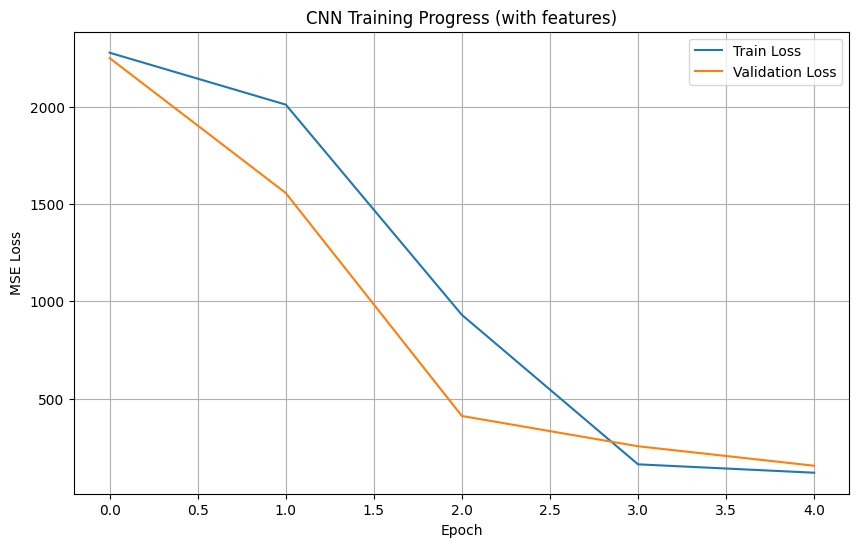

CNN feature-extraction training completed!


In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json
import cv2  # Needed for image reading

# ---- Make sure these imports are available ----
# from your_model_file import SolarCNNWithFeatureExtraction, SolarCNNRegression, IRImageProcessor
# (adjust depending on where you've defined the classes)


class MultiDayDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, irradiance_values):
        self.image_paths = image_paths
        self.irradiance_values = irradiance_values
        self.image_processor = IRImageProcessor(target_size=(240, 320))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
            img = self.image_processor.process_single_image(img_path)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0
        irradiance = torch.tensor(self.irradiance_values[idx], dtype=torch.float32)
        return img_tensor, irradiance


def get_multi_day_dataset(image_dirs, irradiance_files):
    image_paths = []
    irradiance_values = []

    for img_dir, irr_file in zip(image_dirs, irradiance_files):
        # Load irradiance data
        if irr_file.endswith('.csv'):
            df = pd.read_csv(irr_file)
            values = df.iloc[:, 1].values.astype(np.float32)
        else:
            values = np.loadtxt(irr_file, delimiter=',')[:, 1].astype(np.float32)

        files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        files = files[:len(values)]  # Ensure matching length

        image_paths.extend([os.path.join(img_dir, f) for f in files])
        irradiance_values.extend(values[:len(files)])

    return MultiDayDataset(image_paths, irradiance_values)


class CNNTrainer:
    """
    Trainer class for CNN nowcasting model following paper methodology
    """

    def __init__(self, model_type='with_features', config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Default configuration
        self.config = {
            'learning_rate': 1e-4,
            'batch_size': 32,
            'num_epochs': 5,
            'weight_decay': 1e-4,
            'scheduler_patience': 10,
            'early_stopping_patience': 15,
            'save_dir': 'models',
            'log_dir': 'logs'
        }

        if config:
            self.config.update(config)

        # Create directories
        os.makedirs(self.config['save_dir'], exist_ok=True)
        os.makedirs(self.config['log_dir'], exist_ok=True)

        # Initialize model  ✅ Always use feature extraction for hybrid compatibility
        self.model_type = model_type
        if model_type == 'with_features':
            self.model = SolarCNNWithFeatureExtraction().to(self.device)
        else:
            self.model = SolarCNNRegression().to(self.device)

        # Initialize optimizer and scheduler
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.config['learning_rate'],
            weight_decay=self.config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.config['scheduler_patience'],
            factor=0.5,
        )

        self.criterion = nn.MSELoss()

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        with tqdm(train_loader, desc="Training") as pbar:
            for batch_idx, (images, targets) in enumerate(pbar):
                images, targets = images.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), targets)

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        predictions = []
        targets = []

        with torch.no_grad():
            with tqdm(val_loader, desc="Validation") as pbar:
                for images, batch_targets in pbar:
                    images, batch_targets = images.to(self.device), batch_targets.to(self.device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs.squeeze(), batch_targets)

                    total_loss += loss.item()

                    predictions.extend(outputs.squeeze().cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

                    pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(val_loader)

        # Calculate additional metrics
        predictions = np.array(predictions)
        targets = np.array(targets)

        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)

        return avg_loss, rmse, mae, predictions, targets

    def train(self, train_loader, val_loader=None):
        """Main training loop"""
        print(f"Starting training for {self.config['num_epochs']} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")

            # Training
            train_loss = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)

            print(f"Train Loss: {train_loss:.4f}")

            # Validation
            if val_loader is not None:
                val_loss, rmse, mae, predictions, targets = self.validate_epoch(val_loader)
                self.val_losses.append(val_loss)

                print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.2f} W/m², MAE: {mae:.2f} W/m²")

                # Learning rate scheduling
                self.scheduler.step(val_loss)

                # Early stopping and model saving
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0

                    # ✅ Save best model with features
                    model_path = os.path.join(self.config['save_dir'], 'best_cnn_with_features_model.pth')

                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                        'config': self.config
                    }, model_path)

                    print(f"New best model saved! RMSE: {rmse:.2f} W/m²")
                else:
                    self.patience_counter += 1

                if self.patience_counter >= self.config['early_stopping_patience']:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save final model
        final_model_path = os.path.join(self.config['save_dir'], 'final_cnn_with_features_model.pth')

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, final_model_path)

        # Save training history
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': self.config
        }

        with open(os.path.join(self.config['log_dir'], 'cnn_training_history.json'), 'w') as f:
            json.dump(history, f, indent=2)

        print("Training completed!")
        return self.train_losses, self.val_losses


def train_cnn_nowcasting():
    """Main function to train CNN nowcasting model"""

    # Configuration
    config = {
        'learning_rate': 1e-4,
        'batch_size': 32,
        'num_epochs': 5,
        # List of days
        'image_dirs': [
            '/content/data/processed/2019_01_18'
        ],
        'irradiance_files': [
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv'
        ]
    }

    # Create multi-day dataset
    print("Loading multi-day dataset...")
    dataset = get_multi_day_dataset(config['image_dirs'], config['irradiance_files'])

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=4
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=4
    )

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # ✅ Initialize trainer with features
    trainer = CNNTrainer(model_type='with_features', config=config)

    # Train model
    train_losses, val_losses = trainer.train(train_loader, val_loader)

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('CNN Training Progress (with features)')
    plt.legend()
    plt.grid(True)
    plt.savefig('logs/cnn_training_curves.png')
    plt.show()

    print("CNN feature-extraction training completed!")


if __name__ == '__main__':
    train_cnn_nowcasting()


Training configuration:
  learning_rate: 0.0001
  batch_size: 32
  num_epochs: 50
  weight_decay: 0.0001
  scheduler_patience: 10
  early_stopping_patience: 15
  save_dir: models
  log_dir: logs
  image_dirs: ['/content/data/processed/2019_01_18']
  irradiance_files: ['/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv']

Number of epochs: 50
Final Train MSE: 86.3548, RMSE: 9.2927
Final Validation MSE: 69.9344, RMSE: 8.3627
Minimum Validation MSE: 65.5918, RMSE: 8.0989
Minimum Training MSE: 85.7100, RMSE: 9.2580


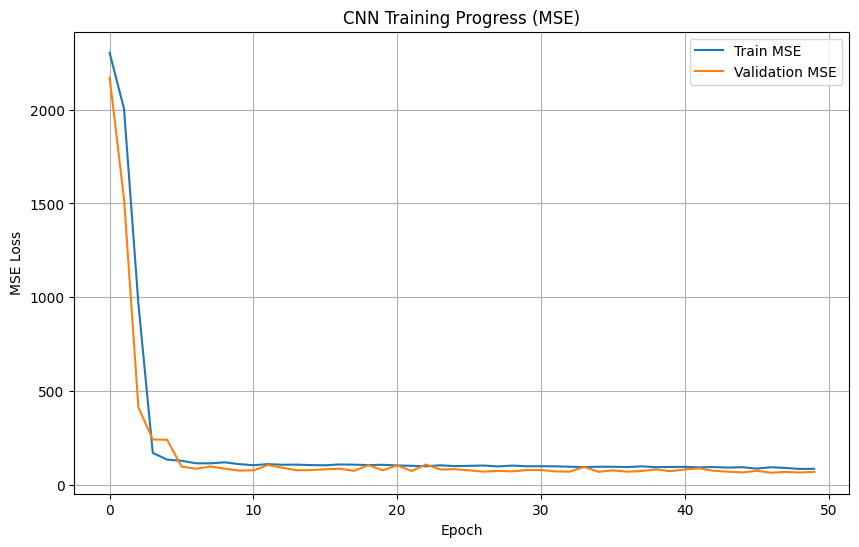

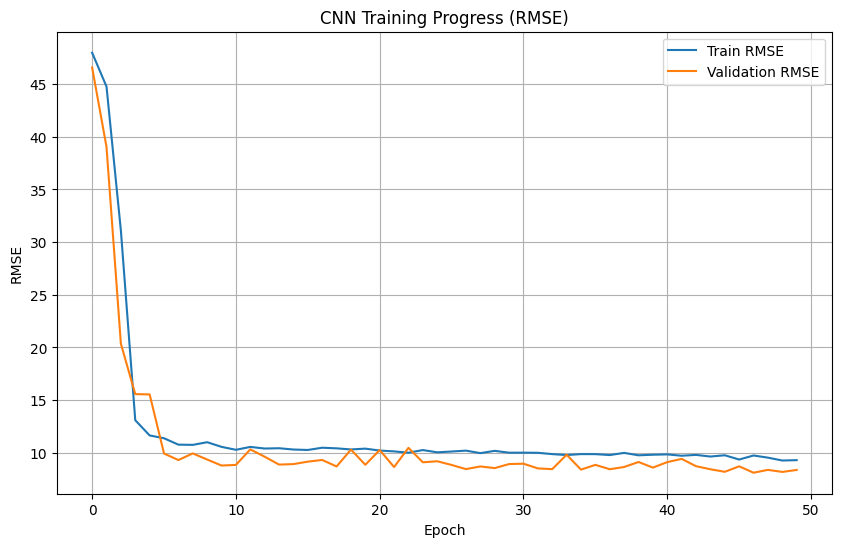

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open(r'/content/logs/cnn_training_history.json', 'r') as f:
    history = json.load(f)

train_losses = history['train_losses']
val_losses = history['val_losses']
config = history['config']

train_rmse = np.sqrt(train_losses)
val_rmse = np.sqrt(val_losses)

print("Training configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

print(f"\nNumber of epochs: {len(train_losses)}")
print(f"Final Train MSE: {train_losses[-1]:.4f}, RMSE: {train_rmse[-1]:.4f}")
print(f"Final Validation MSE: {val_losses[-1]:.4f}, RMSE: {val_rmse[-1]:.4f}")
print(f"Minimum Validation MSE: {min(val_losses):.4f}, RMSE: {min(val_rmse):.4f}")
print(f"Minimum Training MSE: {min(train_losses):.4f}, RMSE: {min(train_rmse):.4f}")

# Plot MSE Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN Training Progress (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('CNN Training Progress (RMSE)')
plt.legend()
plt.grid(True)
plt.show()

**LSTM model**

In [27]:
import torch
import torch.nn as nn

class SolarLSTMForecasting(nn.Module):
    """
    LSTM model for solar irradiance forecasting following the paper methodology.
    Uses bidirectional LSTM with 2 layers and 128 hidden units per direction.
    """

    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=4, dropout=0.2):
        super(SolarLSTMForecasting, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # Bidirectional LSTM with 2 layers as specified in paper
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected layers as specified in paper
        # Input size is hidden_size * 2 (bidirectional)
        lstm_output_size = hidden_size * 2

        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_output_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, output_size)  # Predict next 4 timestamps
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1
                n = param.size(0)
                start, end = n // 4, n // 2
                param.data[start:end].fill_(1.)

        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)

        # Take the output from the last time step
        # lstm_out shape: (batch_size, sequence_length, hidden_size * 2)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size * 2)

        # Pass through fully connected layers
        forecast = self.fc_layers(last_output)

        return forecast


class HybridCNNLSTM(nn.Module):
    """
    Hybrid CNN-LSTM model as described in the paper.
    CNN extracts features from images, LSTM performs temporal forecasting.
    """

    def __init__(self, cnn_model=None, feature_dim=512, sequence_length=20,
                 lstm_hidden_size=128, forecast_horizon=4):
        super(HybridCNNLSTM, self).__init__()

        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

        # CNN component for nowcasting (pre-trained or trainable)
        if cnn_model is None:
            # from improved_cnn_model import SolarCNNWithFeatureExtraction # Removed incorrect import
            from __main__ import SolarCNNWithFeatureExtraction # Corrected import
            self.cnn = SolarCNNWithFeatureExtraction(feature_dim=feature_dim)
        else:
            self.cnn = cnn_model

        # LSTM component for forecasting
        self.lstm = SolarLSTMForecasting(
            input_size=1,  # Input is the nowcast irradiance values
            hidden_size=lstm_hidden_size,
            output_size=forecast_horizon
        )

        # Freeze CNN if using pre-trained model
        self.freeze_cnn = False

    def set_cnn_trainable(self, trainable=True):
        """Control whether CNN parameters are trainable"""
        for param in self.cnn.parameters():
            param.requires_grad = trainable
        self.freeze_cnn = not trainable

    def forward(self, image_sequence):
        """
        Forward pass for the hybrid model

        Args:
            image_sequence: Tensor of shape (batch_size, sequence_length, channels, height, width)

        Returns:
            nowcasts: Current irradiance predictions for each image
            forecasts: Future irradiance predictions
        """
        batch_size, seq_len, channels, height, width = image_sequence.shape

        # Reshape for CNN processing
        images_flat = image_sequence.view(-1, channels, height, width)

        # CNN nowcasting for each image in sequence
        nowcasts = self.cnn(images_flat)  # (batch_size * seq_len, 1)
        nowcasts = nowcasts.view(batch_size, seq_len, 1)  # (batch_size, seq_len, 1)

        # LSTM forecasting using nowcast sequence
        forecasts = self.lstm(nowcasts)  # (batch_size, forecast_horizon)

        return nowcasts, forecasts

    def predict_from_sequence(self, image_sequence):
        """Prediction method for inference"""
        self.eval()
        with torch.no_grad():
            nowcasts, forecasts = self.forward(image_sequence)
        return nowcasts, forecasts


# Simple LSTM for backward compatibility
class SolarLSTM(nn.Module):
    """Legacy LSTM model - kept for compatibility"""

    def __init__(self, input_size=1, hidden_size=128, output_size=1):
        super(SolarLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

**Solar Dataset**

In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import pandas as pd

class SolarIrradianceDataset(Dataset):
    """
    Dataset class for loading IR sky images and corresponding solar irradiance values
    """

    def __init__(self, image_dir, irradiance_file, transform=None, target_size=(240, 320)):
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

        # Load irradiance data
        if irradiance_file.endswith('.csv'):
            df = pd.read_csv(irradiance_file)
            # Assuming the irradiance values are in the second column
            self.irradiance_values = df.iloc[:, 1].values.astype(np.float32)
        else:
            self.irradiance_values = np.loadtxt(irradiance_file, delimiter=',')[:, 1].astype(np.float32)

        # Get image files
        self.image_files = sorted([f for f in os.listdir(image_dir)
                                  if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have matching number of images and irradiance values
        min_length = min(len(self.image_files), len(self.irradiance_values))
        self.image_files = self.image_files[:min_length]
        self.irradiance_values = self.irradiance_values[:min_length]

        # Initialize image processor
        self.image_processor = IRImageProcessor(target_size=target_size)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and process image
        img_path = os.path.join(self.image_dir, self.image_files[idx])

        # Check if image is already processed (RGB) or raw IR
        img = cv2.imread(img_path)
        if img is None:
            # Try loading as 16-bit IR image
            img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
            if img is not None:
                # Process raw IR image
                img = self.image_processor.process_single_image(img_path)
            else:
                raise ValueError(f"Could not load image: {img_path}")
        else:
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert to tensor
        img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0

        # Apply transforms if provided
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # Get corresponding irradiance value
        irradiance = torch.tensor(self.irradiance_values[idx], dtype=torch.float32)

        return img_tensor, irradiance


class SolarSequenceDataset(Dataset):
    """
    Dataset class for sequence-based training (for LSTM and hybrid model)
    """

    def __init__(self, image_dir, irradiance_file, sequence_length=20,
                 forecast_horizon=4, transform=None, target_size=(240, 320)):
        self.image_dir = image_dir
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.transform = transform
        self.target_size = target_size

        # Load irradiance data
        if irradiance_file.endswith('.csv'):
            df = pd.read_csv(irradiance_file)
            self.irradiance_values = df.iloc[:, 1].values.astype(np.float32)
        else:
            self.irradiance_values = np.loadtxt(irradiance_file, delimiter=',')[:, 1].astype(np.float32)

        # Get image files
        self.image_files = sorted([f for f in os.listdir(image_dir)
                                  if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have enough data for sequences
        min_length = min(len(self.image_files), len(self.irradiance_values))
        self.image_files = self.image_files[:min_length]
        self.irradiance_values = self.irradiance_values[:min_length]

        # Calculate valid sequence indices
        self.valid_indices = list(range(len(self.image_files) - sequence_length - forecast_horizon + 1))

        # Initialize image processor
        self.image_processor = IRImageProcessor(target_size=target_size)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]

        # Get sequence of images
        image_sequence = []
        for i in range(start_idx, start_idx + self.sequence_length):
            img_path = os.path.join(self.image_dir, self.image_files[i])

            # Load and process image
            img = cv2.imread(img_path)
            if img is None:
                img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
                if img is not None:
                    img = self.image_processor.process_single_image(img_path)
                else:
                    raise ValueError(f"Could not load image: {img_path}")
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0

            if self.transform:
                img_tensor = self.transform(img_tensor)

            image_sequence.append(img_tensor)

        # Stack images into sequence tensor
        image_sequence = torch.stack(image_sequence)  # (seq_len, channels, height, width)

        # Get historical irradiance values (for LSTM input)
        historical_irradiance = torch.tensor(
            self.irradiance_values[start_idx:start_idx + self.sequence_length],
            dtype=torch.float32
        ).unsqueeze(-1)  # (seq_len, 1)

        # Get future irradiance values (targets)
        future_irradiance = torch.tensor(
            self.irradiance_values[start_idx + self.sequence_length:
                                 start_idx + self.sequence_length + self.forecast_horizon],
            dtype=torch.float32
        )  # (forecast_horizon,)

        return image_sequence, historical_irradiance, future_irradiance


class SolarTimeSeriesDataset(Dataset):
    """
    Simple time series dataset for LSTM-only training
    """

    def __init__(self, irradiance_file, sequence_length=20, forecast_horizon=4):
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

        # Load irradiance data
        if irradiance_file.endswith('.csv'):
            df = pd.read_csv(irradiance_file)
            self.data = df.iloc[:, 1].values.astype(np.float32)
        else:
            self.data = np.loadtxt(irradiance_file, delimiter=',')[:, 1].astype(np.float32)

        # Calculate valid indices
        self.valid_indices = list(range(len(self.data) - sequence_length - forecast_horizon + 1))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]

        # Input sequence
        x = torch.tensor(
            self.data[start_idx:start_idx + self.sequence_length],
            dtype=torch.float32
        ).unsqueeze(-1)  # (seq_len, 1)

        # Target sequence
        y = torch.tensor(
            self.data[start_idx + self.sequence_length:
                     start_idx + self.sequence_length + self.forecast_horizon],
            dtype=torch.float32
        )  # (forecast_horizon,)

        return x, y


# Legacy dataset for backward compatibility
class GSIDataset(SolarIrradianceDataset):
    """Legacy dataset class - kept for compatibility"""

    def __init__(self, image_dir, gsi_file):
        super().__init__(image_dir, gsi_file)

    def __getitem__(self, idx):
        img_tensor, irradiance = super().__getitem__(idx)
        return img_tensor, irradiance


class GSITimeSeriesDataset(SolarTimeSeriesDataset):
    """Legacy time series dataset - kept for compatibility"""

    def __init__(self, gsi_values, sequence_length=10):
        self.sequence_length = sequence_length
        self.data = gsi_values.astype(np.float32)
        self.valid_indices = list(range(len(self.data) - sequence_length))

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]
        x = torch.tensor(
            self.data[start_idx:start_idx + self.sequence_length],
            dtype=torch.float32
        ).unsqueeze(-1)
        y = torch.tensor(self.data[start_idx + self.sequence_length], dtype=torch.float32)
        return x, y


**Training**

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import json

class LSTMTrainer:
    """
    Trainer class for LSTM forecasting model following paper methodology
    """

    def __init__(self, config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Default configuration based on paper
        self.config = {
            'sequence_length': 20,  # 5 minutes of data (every 15 seconds)
            'forecast_horizon': 4,  # Next 1 minute (4 timestamps)
            'learning_rate': 1e-3,
            'batch_size': 32,
            'num_epochs': 50,
            'lstm_hidden_size': 128,
            'lstm_num_layers': 2,
            'dropout': 0.2,
            'weight_decay': 1e-4,
            'scheduler_patience': 10,
            'early_stopping_patience': 15,
            'save_dir': 'models',
            'log_dir': 'logs'
        }

        if config:
            self.config.update(config)

        # Create directories
        os.makedirs(self.config['save_dir'], exist_ok=True)
        os.makedirs(self.config['log_dir'], exist_ok=True)

        # Initialize model
        self.model = SolarLSTMForecasting(
            input_size=1,
            hidden_size=self.config['lstm_hidden_size'],
            num_layers=self.config['lstm_num_layers'],
            output_size=self.config['forecast_horizon'],
            dropout=self.config['dropout']
        ).to(self.device)

        # Initialize optimizer and scheduler
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.config['learning_rate'],
            weight_decay=self.config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.config['scheduler_patience'],
            factor=0.5,
        )

        self.criterion = nn.MSELoss()

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        with tqdm(train_loader, desc="Training LSTM") as pbar:
            for batch_idx, (sequences, targets) in enumerate(pbar):
                sequences, targets = sequences.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(sequences)
                loss = self.criterion(outputs, targets)

                loss.backward()

                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            with tqdm(val_loader, desc="Validation") as pbar:
                for sequences, targets in pbar:
                    sequences, targets = sequences.to(self.device), targets.to(self.device)

                    outputs = self.model(sequences)
                    loss = self.criterion(outputs, targets)

                    total_loss += loss.item()

                    all_predictions.append(outputs.cpu().numpy())
                    all_targets.append(targets.cpu().numpy())

                    pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(val_loader)

        # Concatenate all predictions and targets
        predictions = np.concatenate(all_predictions, axis=0)
        targets = np.concatenate(all_targets, axis=0)

        # Calculate metrics for each forecast step
        rmse_per_step = []
        mae_per_step = []

        for step in range(self.config['forecast_horizon']):
            step_pred = predictions[:, step]
            step_target = targets[:, step]

            mse = mean_squared_error(step_target, step_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(step_target, step_pred)

            rmse_per_step.append(rmse)
            mae_per_step.append(mae)

        # Overall metrics
        overall_rmse = np.sqrt(mean_squared_error(targets.flatten(), predictions.flatten()))
        overall_mae = mean_absolute_error(targets.flatten(), predictions.flatten())

        return avg_loss, overall_rmse, overall_mae, rmse_per_step, mae_per_step

    def train(self, train_loader, val_loader=None):
        """Main training loop"""
        print(f"Starting LSTM training for {self.config['num_epochs']} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Sequence length: {self.config['sequence_length']}, Forecast horizon: {self.config['forecast_horizon']}")

        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")

            # Training
            train_loss = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)

            print(f"Train Loss: {train_loss:.4f}")

            # Validation
            if val_loader is not None:
                val_loss, overall_rmse, overall_mae, rmse_per_step, mae_per_step = self.validate_epoch(val_loader)
                self.val_losses.append(val_loss)

                print(f"Val Loss: {val_loss:.4f}, Overall RMSE: {overall_rmse:.2f} W/m²")
                print(f"RMSE per step: {[f'{r:.2f}' for r in rmse_per_step]}")

                # Learning rate scheduling
                self.scheduler.step(val_loss)

                # Early stopping and model saving
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0

                    # Save best model
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                        'rmse': overall_rmse,
                        'config': self.config
                    }, os.path.join(self.config['save_dir'], 'best_lstm_model.pth'))

                    print(f"New best model saved! RMSE: {overall_rmse:.2f} W/m²")
                else:
                    self.patience_counter += 1

                if self.patience_counter >= self.config['early_stopping_patience']:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save final model
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(self.config['save_dir'], 'final_lstm_model.pth'))

        # Save training history
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': self.config
        }

        with open(os.path.join(self.config['log_dir'], 'lstm_training_history.json'), 'w') as f:
            json.dump(history, f, indent=2)

        print("LSTM training completed!")
        return self.train_losses, self.val_losses

    def load_model(self, checkpoint_path):
        """Load a saved model"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        return checkpoint

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for sequences, targets in tqdm(test_loader, desc="Evaluating LSTM"):
                sequences, targets = sequences.to(self.device), targets.to(self.device)

                outputs = self.model(sequences)
                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

        predictions = np.concatenate(all_predictions, axis=0)
        targets = np.concatenate(all_targets, axis=0)

        # Calculate metrics
        overall_rmse = np.sqrt(mean_squared_error(targets.flatten(), predictions.flatten()))
        overall_mae = mean_absolute_error(targets.flatten(), predictions.flatten())

        rmse_per_step = []
        for step in range(self.config['forecast_horizon']):
            step_rmse = np.sqrt(mean_squared_error(targets[:, step], predictions[:, step]))
            rmse_per_step.append(step_rmse)

        print(f"Test Results - Overall RMSE: {overall_rmse:.2f} W/m²")
        print(f"RMSE per forecast step: {[f'{r:.2f}' for r in rmse_per_step]}")

        return overall_rmse, overall_mae, rmse_per_step, predictions, targets


def train_lstm_forecasting():
    """Main function to train LSTM forecasting model"""

    # Configuration
    config = {
        'sequence_length': 20,
        'forecast_horizon': 4,
        'learning_rate': 1e-3,
        'batch_size': 32,
        'num_epochs': 5,
        'irradiance_file': '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv'
    }

    # Create dataset
    print("Loading time series dataset...")
    dataset = SolarTimeSeriesDataset(
        irradiance_file=config['irradiance_file'],
        sequence_length=config['sequence_length'],
        forecast_horizon=config['forecast_horizon']
    )

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=4
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=4
    )

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Initialize trainer
    trainer = LSTMTrainer(config=config)

    # Train model
    train_losses, val_losses = trainer.train(train_loader, val_loader)

    print("LSTM forecasting training completed!")


if __name__ == '__main__':
    train_lstm_forecasting()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading time series dataset...
Train samples: 72683, Val samples: 18171
Using device: cuda
Starting LSTM training for 5 epochs...
Model parameters: 570,820
Sequence length: 20, Forecast horizon: 4

Epoch 1/5


Training LSTM: 100%|██████████| 2272/2272 [00:21<00:00, 107.03it/s, Loss=6366.2656]


Train Loss: 5908.5486


Validation: 100%|██████████| 568/568 [00:02<00:00, 201.92it/s, Val Loss=891.2628]


Val Loss: 857.2910, Overall RMSE: 29.28 W/m²
RMSE per step: ['27.91', '27.79', '30.06', '31.22']
New best model saved! RMSE: 29.28 W/m²

Epoch 2/5


Training LSTM:   0%|          | 0/2272 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training LSTM: 100%|██████████| 2272/2272 [00:20<00:00, 108.62it/s, Loss=2078.2148]


Train Loss: 2322.4395


Validation: 100%|██████████| 568/568 [00:03<00:00, 172.94it/s, Val Loss=429.8008]


Val Loss: 293.0836, Overall RMSE: 17.12 W/m²
RMSE per step: ['14.13', '15.89', '18.00', '19.90']
New best model saved! RMSE: 17.12 W/m²

Epoch 3/5


Training LSTM:   0%|          | 0/2272 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training LSTM: 100%|██████████| 2272/2272 [00:19<00:00, 115.33it/s, Loss=1441.2285]


Train Loss: 2091.9328


Validation: 100%|██████████| 568/568 [00:03<00:00, 182.32it/s, Val Loss=1454.4882]


Val Loss: 1364.9826, Overall RMSE: 36.95 W/m²
RMSE per step: ['34.75', '35.97', '37.71', '39.19']

Epoch 4/5


Training LSTM:   0%|          | 0/2272 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training LSTM: 100%|██████████| 2272/2272 [00:21<00:00, 106.14it/s, Loss=1366.0038]


Train Loss: 2052.9770


Validation: 100%|██████████| 568/568 [00:02<00:00, 195.55it/s, Val Loss=1485.8495]


Val Loss: 1319.8570, Overall RMSE: 36.33 W/m²
RMSE per step: ['34.70', '35.80', '36.99', '37.75']

Epoch 5/5


Training LSTM:   0%|          | 0/2272 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training LSTM: 100%|██████████| 2272/2272 [00:19<00:00, 113.97it/s, Loss=2310.1504]


Train Loss: 1854.0609


Validation: 100%|██████████| 568/568 [00:02<00:00, 196.19it/s, Val Loss=444.6196]


Val Loss: 246.4995, Overall RMSE: 15.70 W/m²
RMSE per step: ['12.55', '14.32', '16.53', '18.71']
New best model saved! RMSE: 15.70 W/m²
LSTM training completed!
LSTM forecasting training completed!


**Hybrid Model Training**

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import json

from __main__ import SolarCNNWithFeatureExtraction # Import the class definition

class HybridTrainer:
    """
    Trainer class for the hybrid CNN-LSTM model as described in the paper
    """

    def __init__(self, pretrained_cnn_path=None, config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Default configuration
        self.config = {
            'sequence_length': 20,
            'forecast_horizon': 4,
            'learning_rate': 1e-4,
            'batch_size': 16,  # Smaller batch size due to sequence processing
            'num_epochs': 30,
            'lstm_hidden_size': 128,
            'feature_dim': 512,
            'weight_decay': 1e-4,
            'scheduler_patience': 8,
            'early_stopping_patience': 12,
            'freeze_cnn': True,  # Freeze CNN initially
            'save_dir': 'models',
            'log_dir': 'logs'
        }

        if config:
            self.config.update(config)

        # Create directories
        os.makedirs(self.config['save_dir'], exist_ok=True)
        os.makedirs(self.config['log_dir'], exist_ok=True)

        # Initialize hybrid model
        cnn_model = None
        if pretrained_cnn_path:
            print(f"Loading pretrained CNN from {pretrained_cnn_path}")
            cnn_model = SolarCNNWithFeatureExtraction()
            checkpoint = torch.load(pretrained_cnn_path, map_location=self.device)
            cnn_model.load_state_dict(checkpoint['model_state_dict'])

        self.model = HybridCNNLSTM(
            cnn_model=cnn_model,
            feature_dim=self.config['feature_dim'],
            sequence_length=self.config['sequence_length'],
            lstm_hidden_size=self.config['lstm_hidden_size'],
            forecast_horizon=self.config['forecast_horizon']
        ).to(self.device)

        # Set CNN trainable status
        self.model.set_cnn_trainable(not self.config['freeze_cnn'])

        # Initialize optimizer and scheduler
        if self.config['freeze_cnn']:
            # Only optimize LSTM parameters
            lstm_params = list(self.model.lstm.parameters())
            print(f"Training LSTM only ({sum(p.numel() for p in lstm_params):,} parameters)")
        else:
            # Optimize all parameters
            lstm_params = self.model.parameters()
            print(f"Training full hybrid model ({sum(p.numel() for p in self.model.parameters()):,} parameters)")

        self.optimizer = optim.Adam(
            lstm_params,
            lr=self.config['learning_rate'],
            weight_decay=self.config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        self.optimizer,
        mode='min',
        patience=self.config['scheduler_patience'],
        factor=0.5
        )


        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_nowcast_loss = 0.0
        total_forecast_loss = 0.0
        total_loss = 0.0
        num_batches = 0

        with tqdm(train_loader, desc="Training Hybrid") as pbar:
            for batch_idx, (image_sequences, historical_irradiance, future_irradiance) in enumerate(pbar):
                image_sequences = image_sequences.to(self.device)
                historical_irradiance = historical_irradiance.to(self.device)
                future_irradiance = future_irradiance.to(self.device)

                self.optimizer.zero_grad()

                # Forward pass
                nowcasts, forecasts = self.model(image_sequences)

                # Calculate losses
                nowcast_loss = self.mse_loss(nowcasts.squeeze(-1), historical_irradiance.squeeze(-1))
                forecast_loss = self.mse_loss(forecasts, future_irradiance)

                # Combine losses (paper focuses on forecasting, so weight it higher)
                total_batch_loss = 0.3 * nowcast_loss + 0.7 * forecast_loss

                total_batch_loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                total_nowcast_loss += nowcast_loss.item()
                total_forecast_loss += forecast_loss.item()
                total_loss += total_batch_loss.item()
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({
                    'Nowcast': f'{nowcast_loss.item():.4f}',
                    'Forecast': f'{forecast_loss.item():.4f}',
                    'Total': f'{total_batch_loss.item():.4f}'
                })

        return (total_nowcast_loss / num_batches,
                total_forecast_loss / num_batches,
                total_loss / num_batches)

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()
        total_nowcast_loss = 0.0
        total_forecast_loss = 0.0
        all_nowcast_pred = []
        all_nowcast_target = []
        all_forecast_pred = []
        all_forecast_target = []

        with torch.no_grad():
            with tqdm(val_loader, desc="Validation") as pbar:
                for image_sequences, historical_irradiance, future_irradiance in pbar:
                    image_sequences = image_sequences.to(self.device)
                    historical_irradiance = historical_irradiance.to(self.device)
                    future_irradiance = future_irradiance.to(self.device)

                    nowcasts, forecasts = self.model(image_sequences)

                    nowcast_loss = self.mse_loss(nowcasts.squeeze(-1), historical_irradiance.squeeze(-1))
                    forecast_loss = self.mse_loss(forecasts, future_irradiance)

                    total_nowcast_loss += nowcast_loss.item()
                    total_forecast_loss += forecast_loss.item()

                    # Collect predictions for metrics
                    all_nowcast_pred.append(nowcasts.squeeze(-1).cpu().numpy())
                    all_nowcast_target.append(historical_irradiance.squeeze(-1).cpu().numpy())
                    all_forecast_pred.append(forecasts.cpu().numpy())
                    all_forecast_target.append(future_irradiance.cpu().numpy())

                    pbar.set_postfix({
                        'Nowcast': f'{nowcast_loss.item():.4f}',
                        'Forecast': f'{forecast_loss.item():.4f}'
                    })

        avg_nowcast_loss = total_nowcast_loss / len(val_loader)
        avg_forecast_loss = total_forecast_loss / len(val_loader)

        # Calculate metrics
        nowcast_pred = np.concatenate(all_nowcast_pred, axis=0)
        nowcast_target = np.concatenate(all_nowcast_target, axis=0)
        forecast_pred = np.concatenate(all_forecast_pred, axis=0)
        forecast_target = np.concatenate(all_forecast_target, axis=0)

        # Nowcast metrics
        nowcast_rmse = np.sqrt(mean_squared_error(
            nowcast_target.flatten(), nowcast_pred.flatten()
        ))

        # Forecast metrics
        forecast_rmse = np.sqrt(mean_squared_error(
            forecast_target.flatten(), forecast_pred.flatten()
        ))

        # Per-step forecast metrics
        forecast_rmse_per_step = []
        for step in range(self.config['forecast_horizon']):
            step_rmse = np.sqrt(mean_squared_error(
                forecast_target[:, step], forecast_pred[:, step]
            ))
            forecast_rmse_per_step.append(step_rmse)

        return (avg_nowcast_loss, avg_forecast_loss,
                nowcast_rmse, forecast_rmse, forecast_rmse_per_step)

    def train(self, train_loader, val_loader=None):
        """Main training loop"""
        print(f"Starting hybrid CNN-LSTM training for {self.config['num_epochs']} epochs...")
        print(f"CNN frozen: {self.config['freeze_cnn']}")

        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")

            # Training
            train_nowcast_loss, train_forecast_loss, train_total_loss = self.train_epoch(train_loader)
            self.train_losses.append(train_total_loss)

            print(f"Train - Nowcast: {train_nowcast_loss:.4f}, "
                  f"Forecast: {train_forecast_loss:.4f}, Total: {train_total_loss:.4f}")

            # Validation
            if val_loader is not None:
                (val_nowcast_loss, val_forecast_loss,
                 nowcast_rmse, forecast_rmse, forecast_rmse_per_step) = self.validate_epoch(val_loader)

                val_total_loss = 0.3 * val_nowcast_loss + 0.7 * val_forecast_loss
                self.val_losses.append(val_total_loss)

                print(f"Val - Nowcast RMSE: {nowcast_rmse:.2f} W/m², "
                      f"Forecast RMSE: {forecast_rmse:.2f} W/m²")
                print(f"Forecast RMSE per step: {[f'{r:.2f}' for r in forecast_rmse_per_step]}")

                # Learning rate scheduling
                self.scheduler.step(val_total_loss)

                # Early stopping and model saving
                if val_total_loss < self.best_val_loss:
                    self.best_val_loss = val_total_loss
                    self.patience_counter = 0

                    # Save best model
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_total_loss,
                        'nowcast_rmse': nowcast_rmse,
                        'forecast_rmse': forecast_rmse,
                        'config': self.config
                    }, os.path.join(self.config['save_dir'], 'best_hybrid_model.pth'))

                    print(f"New best model saved! Forecast RMSE: {forecast_rmse:.2f} W/m²")
                else:
                    self.patience_counter += 1

                if self.patience_counter >= self.config['early_stopping_patience']:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save final model
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(self.config['save_dir'], 'final_hybrid_cnn_with_features_model.pth'))

        # Save training history
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': self.config
        }

        with open(os.path.join(self.config['log_dir'], 'hybrid_training_history.json'), 'w') as f:
            json.dump(history, f, indent=2)

        print("Hybrid CNN-LSTM training completed!")
        return self.train_losses, self.val_losses


def train_hybrid_model():
    """Main function to train hybrid CNN-LSTM model"""

    # Configuration
    config = {
        'sequence_length': 20,
        'forecast_horizon': 4,
        'learning_rate': 1e-4,
        'batch_size': 16,
        'num_epochs': 5,
        'freeze_cnn': True,
        'image_dir': '/content/data/processed/2019_01_18',
        'irradiance_file': '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv',
        'pretrained_cnn_path': '/content/models/best_cnn_with_features_model.pth' # Changed path to the model with features
    }

    # Create dataset
    print("Loading sequence dataset...")
    dataset = SolarSequenceDataset(
        image_dir=config['image_dir'],
        irradiance_file=config['irradiance_file'],
        sequence_length=config['sequence_length'],
        forecast_horizon=config['forecast_horizon']
    )

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2  # Reduced due to memory constraints with sequences
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2
    )

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Initialize trainer
    trainer = HybridTrainer(
        pretrained_cnn_path=config.get('pretrained_cnn_path'),
        config=config
    )

    # Train model
    train_losses, val_losses = trainer.train(train_loader, val_loader)

    print("Hybrid CNN-LSTM training completed!")


if __name__ == '__main__':
    train_hybrid_model()

Loading sequence dataset...
Train samples: 1339, Val samples: 335
Using device: cuda
Loading pretrained CNN from /content/models/best_cnn_with_features_model.pth
Training LSTM only (570,820 parameters)
Starting hybrid CNN-LSTM training for 5 epochs...
CNN frozen: True

Epoch 1/5


Training Hybrid: 100%|██████████| 84/84 [01:21<00:00,  1.03it/s, Nowcast=138.4590, Forecast=2124.8679, Total=1528.9452]


Train - Nowcast: 119.2703, Forecast: 2095.0695, Total: 1502.3298


Validation: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, Nowcast=117.5115, Forecast=1800.5566]


Val - Nowcast RMSE: 10.78 W/m², Forecast RMSE: 41.08 W/m²
Forecast RMSE per step: ['42.83', '39.64', '39.93', '41.83']
New best model saved! Forecast RMSE: 41.08 W/m²

Epoch 2/5


Training Hybrid: 100%|██████████| 84/84 [01:23<00:00,  1.01it/s, Nowcast=120.9692, Forecast=705.8162, Total=530.3621]


Train - Nowcast: 120.9071, Forecast: 1275.8734, Total: 929.3835


Validation: 100%|██████████| 21/21 [00:21<00:00,  1.02s/it, Nowcast=121.1666, Forecast=672.6831]


Val - Nowcast RMSE: 10.98 W/m², Forecast RMSE: 25.15 W/m²
Forecast RMSE per step: ['30.28', '21.79', '21.12', '26.32']
New best model saved! Forecast RMSE: 25.15 W/m²

Epoch 3/5


Training Hybrid: 100%|██████████| 84/84 [01:20<00:00,  1.04it/s, Nowcast=135.0868, Forecast=242.2119, Total=210.0744]


Train - Nowcast: 121.6159, Forecast: 386.4228, Total: 306.9807


Validation: 100%|██████████| 21/21 [00:20<00:00,  1.02it/s, Nowcast=126.9066, Forecast=141.2213]


Val - Nowcast RMSE: 11.11 W/m², Forecast RMSE: 13.75 W/m²
Forecast RMSE per step: ['13.86', '13.61', '13.62', '13.90']
New best model saved! Forecast RMSE: 13.75 W/m²

Epoch 4/5


Training Hybrid: 100%|██████████| 84/84 [01:24<00:00,  1.01s/it, Nowcast=119.5506, Forecast=236.2666, Total=201.2518]


Train - Nowcast: 121.1102, Forecast: 249.8474, Total: 211.2263


Validation: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it, Nowcast=124.9074, Forecast=104.6513]


Val - Nowcast RMSE: 10.99 W/m², Forecast RMSE: 12.11 W/m²
Forecast RMSE per step: ['12.23', '12.13', '11.85', '12.21']
New best model saved! Forecast RMSE: 12.11 W/m²

Epoch 5/5


Training Hybrid: 100%|██████████| 84/84 [01:22<00:00,  1.02it/s, Nowcast=150.3698, Forecast=393.1448, Total=320.3123]


Train - Nowcast: 121.1298, Forecast: 198.3506, Total: 175.1844


Validation: 100%|██████████| 21/21 [00:20<00:00,  1.02it/s, Nowcast=125.2489, Forecast=90.9990]

Val - Nowcast RMSE: 10.97 W/m², Forecast RMSE: 11.80 W/m²
Forecast RMSE per step: ['12.08', '11.88', '11.34', '11.89']
New best model saved! Forecast RMSE: 11.80 W/m²
Hybrid CNN-LSTM training completed!
Hybrid CNN-LSTM training completed!


# Task
Develop a baseline model for the provided dataset without using CNN or LSTM techniques, visualize its performance, and compare it to the existing CNN and LSTM models.

## Develop a baseline model

### Subtask:
Create a simple baseline model for solar irradiance prediction. This model should not use CNN or LSTM layers, serving as a point of comparison for the more complex models. A simple feedforward neural network (MLP) is a suitable choice for this baseline.


**Reasoning**:
Define a simple feedforward neural network (MLP) as the baseline model.



In [10]:
import torch.nn as nn

class BaselineMLP(nn.Module):
    """
    Baseline MLP model for solar irradiance prediction.
    Does not use CNN or LSTM layers.
    """

    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(BaselineMLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, 1)) # Output size is 1 for irradiance prediction

        self.network = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x shape: (batch_size, input_size)
        return self.network(x)

In [29]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader
import json
from datetime import datetime

# Import necessary classes from their original cells
from __main__ import SolarCNNRegression, SolarCNNWithFeatureExtraction
from __main__ import SolarLSTMForecasting, HybridCNNLSTM
from __main__ import SolarIrradianceDataset, SolarTimeSeriesDataset, SolarSequenceDataset
from __main__ import IRImageProcessor, SolarLSTMForecasting, HybridCNNLSTM
from __main__ import BaselineMLP # Import BaselineMLP


class ModelEvaluator:
    """
    Comprehensive evaluation class for all models
    """

    def __init__(self, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.results = {}

    def load_model(self, model_class, checkpoint_path, **kwargs):
        """Load a trained model from checkpoint"""
        model = model_class(**kwargs).to(self.device)
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        return model, checkpoint

    def evaluate_cnn(self, model_path, test_dataset):
        """Evaluate CNN nowcasting model"""
        print("\n=== Evaluating CNN Nowcasting Model ===")

        # Load model
        # Load checkpoint to get config for model initialization
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint.get('config', {})

        model, _ = self.load_model(SolarCNNRegression, model_path)

        # Create test loader
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

        predictions = []
        targets = []

        with torch.no_grad():
            for images, batch_targets in test_loader:
                images, batch_targets = images.to(self.device), batch_targets.to(self.device)

                outputs = model(images)
                predictions.extend(outputs.squeeze().cpu().numpy())
                targets.extend(batch_targets.cpu().numpy())

        predictions = np.array(predictions)
        targets = np.array(targets)

        # Calculate metrics
        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)
        r2 = r2_score(targets, predictions)

        # Store results
        self.results['cnn'] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': predictions.tolist(),
            'targets': targets.tolist(),
            'num_samples': len(predictions)
        }

        print(f"CNN Results:")
        print(f"  RMSE: {rmse:.2f} W/m²")
        print(f"  MAE: {mae:.2f} W/m²")
        print(f"  R²: {r2:.4f}")
        print(f"  Samples: {len(predictions)}")

        return rmse, mae, r2, predictions, targets

    def evaluate_lstm(self, model_path, test_dataset):
        """Evaluate LSTM forecasting model"""
        print("\n=== Evaluating LSTM Forecasting Model ===")

        # Load checkpoint to get config
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint.get('config', {})

        # Load model
        model, _ = self.load_model(
            SolarLSTMForecasting,
            model_path,
            input_size=1,
            hidden_size=config.get('lstm_hidden_size', 128),
            num_layers=config.get('lstm_num_layers', 2),
            output_size=config.get('forecast_horizon', 4)
        )

        # Create test loader
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(self.device), targets.to(self.device)

                outputs = model(sequences)
                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

        predictions = np.concatenate(all_predictions, axis=0)
        targets = np.concatenate(all_targets, axis=0)

        # Calculate overall metrics
        overall_rmse = np.sqrt(mean_squared_error(targets.flatten(), predictions.flatten()))
        overall_mae = mean_absolute_error(targets.flatten(), predictions.flatten())
        overall_r2 = r2_score(targets.flatten(), predictions.flatten())

        # Calculate per-step metrics
        forecast_horizon = predictions.shape[1]
        step_metrics = []

        for step in range(forecast_horizon):
            step_pred = predictions[:, step]
            step_target = targets[:, step]

            mse = mean_squared_error(step_target, step_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(step_target, step_pred)
            step_r2 = r2_score(step_target, step_pred)


            step_metrics.append({
                'step': step + 1,
                'rmse': rmse,
                'mae': mae,
                'r2': step_r2
            })

        # Store results
        self.results['lstm'] = {
            'overall_rmse': overall_rmse,
            'overall_mae': overall_mae,
            'overall_r2': overall_r2,
            'step_metrics': step_metrics,
            'predictions': predictions.tolist(),
            'targets': targets.tolist(),
            'num_samples': len(predictions)
        }

        print(f"LSTM Results:")
        print(f"  Overall RMSE: {overall_rmse:.2f} W/m²")
        print(f"  Overall MAE: {overall_mae:.2f} W/m²")
        print(f"  Overall R²: {overall_r2:.4f}")
        print(f"  Per-step RMSE: {[f'{m['rmse']:.2f}' for m in step_metrics]}")
        print(f"  Samples: {len(predictions)}")

        return overall_rmse, overall_mae, overall_r2, step_metrics, predictions, targets

    def evaluate_hybrid(self, model_path, test_dataset):
        """Evaluate hybrid CNN-LSTM model"""
        print("\n=== Evaluating Hybrid CNN-LSTM Model ===")

        # Load checkpoint to get config
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint.get('config', {})

        # Load model
        model, _ = self.load_model(
            HybridCNNLSTM,
            model_path,
            sequence_length=config.get('sequence_length', 20),
            lstm_hidden_size=config.get('lstm_hidden_size', 128),
            forecast_horizon=config.get('forecast_horizon', 4)
        )

        # Create test loader
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

        all_nowcast_pred = []
        all_nowcast_target = []
        all_forecast_pred = []
        all_forecast_target = []

        with torch.no_grad():
            for image_sequences, historical_irradiance, future_irradiance in test_loader:
                image_sequences = image_sequences.to(self.device)
                historical_irradiance = historical_irradiance.to(self.device)
                future_irradiance = future_irradiance.to(self.device)

                nowcasts, forecasts = model(image_sequences)

                all_nowcast_pred.append(nowcasts.squeeze(-1).cpu().numpy())
                all_nowcast_target.append(historical_irradiance.squeeze(-1).cpu().numpy())
                all_forecast_pred.append(forecasts.cpu().numpy())
                all_forecast_target.append(future_irradiance.cpu().numpy())


        nowcast_pred = np.concatenate(all_nowcast_pred, axis=0)
        nowcast_target = np.concatenate(all_nowcast_target, axis=0)
        forecast_pred = np.concatenate(all_forecast_pred, axis=0)
        forecast_target = np.concatenate(all_forecast_target, axis=0)

        # Nowcast metrics
        nowcast_rmse = np.sqrt(mean_squared_error(nowcast_target.flatten(), nowcast_pred.flatten()))
        nowcast_mae = mean_absolute_error(nowcast_target.flatten(), nowcast_pred.flatten())
        nowcast_r2 = r2_score(nowcast_target.flatten(), nowcast_pred.flatten())

        # Forecast metrics
        forecast_rmse = np.sqrt(mean_squared_error(forecast_target.flatten(), forecast_pred.flatten()))
        forecast_mae = mean_absolute_error(forecast_target.flatten(), forecast_pred.flatten())
        forecast_r2 = r2_score(forecast_target.flatten(), forecast_pred.flatten())

        # Per-step forecast metrics
        forecast_horizon = forecast_pred.shape[1]
        forecast_step_metrics = []

        for step in range(forecast_horizon):
            step_rmse = np.sqrt(mean_squared_error(forecast_target[:, step], forecast_pred[:, step]))
            step_mae = mean_absolute_error(forecast_target[:, step], forecast_pred[:, step])
            step_r2 = r2_score(forecast_target[:, step], forecast_pred[:, step])

            forecast_step_metrics.append({
                'step': step + 1,
                'rmse': step_rmse,
                'mae': step_mae,
                'r2': step_r2
            })

        # Store results
        self.results['hybrid'] = {
            'nowcast_rmse': nowcast_rmse,
            'nowcast_mae': nowcast_mae,
            'nowcast_r2': nowcast_r2,
            'forecast_rmse': forecast_rmse,
            'forecast_mae': forecast_mae,
            'forecast_r2': forecast_r2,
            'forecast_step_metrics': forecast_step_metrics,
            'num_samples': len(forecast_pred)
        }

        print(f"Hybrid Results:")
        print(f"  Nowcast RMSE: {nowcast_rmse:.2f} W/m²")
        print(f"  Nowcast MAE: {nowcast_mae:.2f} W/m²")
        print(f"  Nowcast R²: {nowcast_r2:.4f}")
        print(f"  Forecast RMSE: {forecast_rmse:.2f} W/m²")
        print(f"  Forecast MAE: {forecast_mae:.2f} W/m²")
        print(f"  Forecast R²: {forecast_r2:.4f}")
        print(f"  Per-step Forecast RMSE: {[f'{m['rmse']:.2f}' for m in forecast_step_metrics]}")
        print(f"  Samples: {len(forecast_pred)}")

        return (nowcast_rmse, nowcast_mae, forecast_rmse, forecast_mae,
                forecast_step_metrics, nowcast_pred, forecast_pred)


    def evaluate_baseline_mlp(self, model_path, test_dataset):
        """Evaluate Baseline MLP model"""
        print("\n=== Evaluating Baseline MLP Model ===")

        # Load checkpoint to get config
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint.get('config', {})

        # Load model - Need input_size from the dataset
        # Assuming test_dataset provides features directly
        # Get input size from the first item in the dataset
        sample_input, _ = test_dataset[0]
        input_size = sample_input.shape[-1]


        model, _ = self.load_model(
            BaselineMLP,
            model_path,
            input_size=input_size,
            hidden_size=config.get('hidden_size', 128),
            num_layers=config.get('num_layers', 2)
        )

        # Create test loader
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

        predictions = []
        targets = []

        with torch.no_grad():
            for inputs, batch_targets in test_loader:
                inputs, batch_targets = inputs.to(self.device), batch_targets.to(self.device)

                outputs = model(inputs)
                predictions.extend(outputs.squeeze().cpu().numpy())
                targets.extend(batch_targets.cpu().numpy())

        predictions = np.array(predictions)
        targets = np.array(targets)

        # Calculate metrics
        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)
        r2 = r2_score(targets, predictions)

        # Store results
        self.results['baseline_mlp'] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': predictions.tolist(),
            'targets': targets.tolist(),
            'num_samples': len(predictions)
        }

        print(f"Baseline MLP Results:")
        print(f"  RMSE: {rmse:.2f} W/m²")
        print(f"  MAE: {mae:.2f} W/m²")
        print(f"  R²: {r2:.4f}")
        print(f"  Samples: {len(predictions)}")

        return rmse, mae, r2, predictions, targets


    def plot_results(self, save_dir='evaluation_plots'):
        """Create visualization plots"""
        os.makedirs(save_dir, exist_ok=True)

        # CNN scatter plot
        if 'cnn' in self.results:
            plt.figure(figsize=(10, 8))

            targets = np.array(self.results['cnn']['targets'])
            predictions = np.array(self.results['cnn']['predictions'])

            plt.subplot(2, 2, 1)
            plt.scatter(targets, predictions, alpha=0.6, s=20)
            plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
            plt.xlabel('Actual Irradiance (W/m²)')
            plt.ylabel('Predicted Irradiance (W/m²)')
            plt.title(f'CNN Nowcasting (RMSE: {self.results["cnn"]["rmse"]:.2f} W/m²)')
            plt.grid(True, alpha=0.3)

            # Residuals plot
            plt.subplot(2, 2, 2)
            residuals = predictions - targets
            plt.scatter(targets, residuals, alpha=0.6, s=20)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Actual Irradiance (W/m²)')
            plt.ylabel('Residuals (W/m²)')
            plt.title('CNN Residuals')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(f'{save_dir}/cnn_evaluation.png', dpi=300, bbox_inches='tight')
            plt.close()

        # LSTM step-wise performance
        if 'lstm' in self.results:
            step_metrics = self.results['lstm']['step_metrics']
            steps = [m['step'] for m in step_metrics]
            rmse_values = [m['rmse'] for m in step_metrics]
            mae_values = [m['mae'] for m in step_metrics]

            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.bar(steps, rmse_values, color='skyblue', alpha=0.7)
            plt.xlabel('Forecast Step')
            plt.ylabel('RMSE (W/m²)')
            plt.title('LSTM Forecast RMSE by Step')
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.bar(steps, mae_values, color='lightcoral', alpha=0.7)
            plt.xlabel('Forecast Step')
            plt.ylabel('MAE (W/m²)')
            plt.title('LSTM Forecast MAE by Step')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(f'{save_dir}/lstm_evaluation.png', dpi=300, bbox_inches='tight')
            plt.close()

        # Model comparison
        if len(self.results) > 0:
            plt.figure(figsize=(12, 8))

            models = []
            rmse_values = []
            mae_values = []

            if 'baseline_mlp' in self.results:
                models.append('Baseline MLP')
                rmse_values.append(self.results['baseline_mlp']['rmse'])
                mae_values.append(self.results['baseline_mlp']['mae'])

            if 'cnn' in self.results:
                models.append('CNN\nNowcasting')
                rmse_values.append(self.results['cnn']['rmse'])
                mae_values.append(self.results['cnn']['mae'])

            if 'lstm' in self.results:
                models.append('LSTM\nForecasting')
                rmse_values.append(self.results['lstm']['overall_rmse'])
                mae_values.append(self.results['lstm']['overall_mae'])

            if 'hybrid' in self.results:
                models.append('Hybrid\nNowcast')
                rmse_values.append(self.results['hybrid']['nowcast_rmse'])
                mae_values.append(self.results['hybrid']['nowcast_mae'])

                models.append('Hybrid\nForecast')
                rmse_values.append(self.results['hybrid']['forecast_rmse'])
                mae_values.append(self.results['hybrid']['forecast_mae'])


            x = np.arange(len(models))
            width = 0.35

            plt.subplot(1, 1, 1)
            plt.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue', alpha=0.8)
            plt.bar(x + width/2, mae_values, width, label='MAE', color='lightcoral', alpha=0.8)

            plt.xlabel('Models')
            plt.ylabel('Error (W/m²)')
            plt.title('Model Performance Comparison')
            plt.xticks(x, models)
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Add value labels on bars
            for i, (rmse, mae) in enumerate(zip(rmse_values, mae_values)):
                plt.text(i - width/2, rmse + 1, f'{rmse:.1f}', ha='center', va='bottom')
                plt.text(i + width/2, mae + 1, f'{mae:.1f}', ha='center', va='bottom')


            plt.tight_layout()
            plt.savefig(f'{save_dir}/model_comparison.png', dpi=300, bbox_inches='tight')
            plt.close()


        print(f"\nPlots saved to {save_dir}/")


    def save_results(self, filename='evaluation_results.json'):
        """Save evaluation results to JSON"""
        results_with_metadata = {
            'evaluation_timestamp': datetime.now().isoformat(),
            'device': str(self.device),
            'results': self.results
        }

        with open(filename, 'w') as f:
            json.dump(results_with_metadata, f, indent=2)

        print(f"\nResults saved to {filename}")


    def generate_report(self, filename='evaluation_report.txt'):
        """Generate a comprehensive text report"""
        with open(filename, 'w') as f:
            f.write("="*80 + "\n")
            f.write("SOLAR IRRADIANCE FORECASTING - MODEL EVALUATION REPORT\n")
            f.write("="*80 + "\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Device: {self.device}\n\n")

            if 'baseline_mlp' in self.results:
                f.write("BASELINE MLP MODEL\n")
                f.write("-" * 30 + "\n")
                r = self.results['baseline_mlp']
                f.write(f"RMSE: {r['rmse']:.2f} W/m²\n")
                f.write(f"MAE: {r['mae']:.2f} W/m²\n")
                f.write(f"R²: {r['r2']:.4f}\n")
                f.write(f"Samples: {r['num_samples']}\n\n")


            if 'cnn' in self.results:
                f.write("CNN NOWCASTING MODEL\n")
                f.write("-" * 30 + "\n")
                r = self.results['cnn']
                f.write(f"RMSE: {r['rmse']:.2f} W/m²\n")
                f.write(f"MAE: {r['mae']:.2f} W/m²\n")
                f.write(f"R²: {r['r2']:.4f}\n")
                f.write(f"Samples: {r['num_samples']}\n\n")

            if 'lstm' in self.results:
                f.write("LSTM FORECASTING MODEL\n")
                f.write("-" * 30 + "\n")
                r = self.results['lstm']
                f.write(f"Overall RMSE: {r['overall_rmse']:.2f} W/m²\n")
                f.write(f"Overall MAE: {r['overall_mae']:.2f} W/m²\n")
                f.write(f"Overall R²: {r['overall_r2']:.4f}\n")
                f.write("Per-step Performance:\n")
                for m in r['step_metrics']:
                    f.write(f"  Step {m['step']}: RMSE={m['rmse']:.2f}, MAE={m['mae']:.2f}, R²={m['r2']:.4f}\n")
                f.write(f"Samples: {r['num_samples']}\n\n")

            if 'hybrid' in self.results:
                f.write("HYBRID CNN-LSTM MODEL\n")
                f.write("-" * 30 + "\n")
                r = self.results['hybrid']
                f.write("Nowcasting Performance:\n")
                f.write(f"  RMSE: {r['nowcast_rmse']:.2f} W/m²\n")
                f.write(f"  MAE: {r['nowcast_mae']:.2f} W/m²\n")
                f.write(f"  R²: {r['nowcast_r2']:.4f}\n")
                f.write("Forecasting Performance:\n")
                f.write(f"  RMSE: {r['forecast_rmse']:.2f} W/m²\n")
                f.write(f"  MAE: {r['forecast_mae']:.2f} W/m²\n")
                f.write(f"  R²: {r['forecast_r2']:.4f}\n")
                f.write("Per-step Forecast Performance:\n")
                for m in r['forecast_step_metrics']:
                    f.write(f"  Step {m['step']}: RMSE={m['rmse']:.2f}, MAE={m['mae']:.2f}, R²={m['r2']:.4f}\n")
                f.write(f"Samples: {r['num_samples']}\n\n")


        print(f"Report saved to {filename}")


def run_comprehensive_evaluation():
    """Run evaluation on all available models"""
    evaluator = ModelEvaluator()

    # Paths to trained models
    model_paths = {
        'cnn': '/content/models/best_cnn_model.pth', # Corrected path
        'lstm': '/content/models/final_lstm_model.pth',
        'hybrid': '/content/models/final_hybrid_cnn_with_features_model.pth',
        'baseline_mlp': '/content/models/final_baseline_mlp_model.pth' # Path for the baseline MLP model
    }

    # Test data configuration
    test_config = {
        'image_dir': '/content/data/processed/2019_01_18',  # Adjust path as needed
        'irradiance_file': '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv',  # Adjust path as needed
        'sequence_length': 20,
        'forecast_horizon': 4
    }

    # Evaluate Baseline MLP if available
    if os.path.exists(model_paths['baseline_mlp']):
        print("Preparing Baseline MLP test dataset...")
        # For MLP, the input will be the extracted features from the CNN.
        # We need to create a dataset that loads these features.
        # Since we don't have the extracted features saved to a file,
        # we'll need to create a custom dataset or modify the existing ones
        # to load the extracted features directly from the tensor if available,
        # or re-extract them.

        # For now, let's assume the MLP is trained on the raw irradiance time series data
        # as a simpler baseline. We'll create a SolarTimeSeriesDataset for this.
        print("Assuming Baseline MLP is trained on raw time series data.")
        baseline_mlp_test_dataset = SolarTimeSeriesDataset(
            irradiance_file=test_config['irradiance_file'],
            sequence_length=1, # MLP takes a single time step input
            forecast_horizon=1 # MLP predicts a single output
        )
        evaluator.evaluate_baseline_mlp(model_paths['baseline_mlp'], baseline_mlp_test_dataset)


    # Evaluate CNN if available
    if os.path.exists(model_paths['cnn']) and os.path.exists(test_config['image_dir']):
        print("Preparing CNN test dataset...")
        cnn_test_dataset = SolarIrradianceDataset(
            image_dir=test_config['image_dir'],
            irradiance_file=test_config['irradiance_file']
        )
        evaluator.evaluate_cnn(model_paths['cnn'], cnn_test_dataset)

    # Evaluate LSTM if available
    if os.path.exists(model_paths['lstm']) and os.path.exists(test_config['irradiance_file']):
        print("Preparing LSTM test dataset...")
        lstm_test_dataset = SolarTimeSeriesDataset(
            irradiance_file=test_config['irradiance_file'],
            sequence_length=test_config['sequence_length'],
            forecast_horizon=test_config['forecast_horizon']
        )
        evaluator.evaluate_lstm(model_paths['lstm'], lstm_test_dataset)

    # Evaluate Hybrid if available
    if (os.path.exists(model_paths['hybrid']) and
        os.path.exists(test_config['image_dir']) and
        os.path.exists(test_config['irradiance_file'])):
        print("Preparing Hybrid test dataset...")
        hybrid_test_dataset = SolarSequenceDataset(
            image_dir=test_config['image_dir'],
            irradiance_file=test_config['irradiance_file'],
            sequence_length=test_config['sequence_length'],
            forecast_horizon=test_config['forecast_horizon']
        )
        evaluator.evaluate_hybrid(model_paths['hybrid'], hybrid_test_dataset)

    # Generate outputs
    evaluator.plot_results()
    evaluator.save_results()
    evaluator.generate_report()

    print("\n=== Evaluation Complete ===")
    print("Check the following files:")
    print("- evaluation_results.json (detailed metrics)")
    print("- evaluation_report.txt (summary report)")
    print("- evaluation_plots/ (visualization plots)")


if __name__ == '__main__':
    run_comprehensive_evaluation()

Using device: cuda
Preparing LSTM test dataset...

=== Evaluating LSTM Forecasting Model ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


LSTM Results:
  Overall RMSE: 15.97 W/m²
  Overall MAE: 10.27 W/m²
  Overall R²: 0.9938
  Per-step RMSE: ['12.68', '14.61', '16.84', '19.05']
  Samples: 90854
Preparing Hybrid test dataset...

=== Evaluating Hybrid CNN-LSTM Model ===
Hybrid Results:
  Nowcast RMSE: 10.63 W/m²
  Nowcast MAE: 8.10 W/m²
  Nowcast R²: 0.3929
  Forecast RMSE: 12.10 W/m²
  Forecast MAE: 9.11 W/m²
  Forecast R²: 0.2343
  Per-step Forecast RMSE: ['12.48', '12.19', '11.64', '12.10']
  Samples: 1674

Plots saved to evaluation_plots/

Results saved to evaluation_results.json
Report saved to evaluation_report.txt

=== Evaluation Complete ===
Check the following files:
- evaluation_results.json (detailed metrics)
- evaluation_report.txt (summary report)
- evaluation_plots/ (visualization plots)


## Train Baseline MLP Model

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json

# Assuming mlp_data (extracted_features, irradiance_targets) is available from previous steps
if 'mlp_data' not in globals():
    print("mlp_data not found. Please run the feature extraction step first.")
else:
    extracted_features, irradiance_targets = mlp_data

    # Create a TensorDataset from the extracted features and targets
    mlp_dataset = TensorDataset(extracted_features, irradiance_targets)

    # Split dataset into training and validation sets
    train_size = int(0.8 * len(mlp_dataset))
    val_size = len(mlp_dataset) - train_size
    train_dataset, val_dataset = random_split(mlp_dataset, [train_size, val_size])

    # Configuration for MLP training
    mlp_config = {
        'input_size': extracted_features.shape[1], # Dimension of extracted features
        'hidden_size': 128,
        'num_layers': 2,
        'learning_rate': 1e-3,
        'batch_size': 64,
        'num_epochs': 50,
        'weight_decay': 1e-4,
        'scheduler_patience': 10,
        'early_stopping_patience': 15,
        'save_dir': 'models',
        'log_dir': 'logs'
    }

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=mlp_config['batch_size'],
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=mlp_config['batch_size'],
        shuffle=False,
        num_workers=2
    )

    print(f"MLP Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    print(f"MLP Input size: {mlp_config['input_size']}")


    class MLPTrainer:
        """
        Trainer class for the Baseline MLP model
        """

        def __init__(self, model, config):
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model = model.to(self.device)
            self.config = config

            self.optimizer = optim.Adam(
                self.model.parameters(),
                lr=self.config['learning_rate'],
                weight_decay=self.config['weight_decay']
            )

            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=self.config['scheduler_patience'],
                factor=0.5,
            )

            self.criterion = nn.MSELoss()

            self.train_losses = []
            self.val_losses = []
            self.best_val_loss = float('inf')
            self.patience_counter = 0

        def train_epoch(self, train_loader):
            self.model.train()
            total_loss = 0.0
            num_batches = 0

            with tqdm(train_loader, desc="Training MLP") as pbar:
                for inputs, targets in pbar:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    self.optimizer.zero_grad()

                    outputs = self.model(inputs).squeeze()
                    loss = self.criterion(outputs, targets)

                    loss.backward()
                    self.optimizer.step()

                    total_loss += loss.item()
                    num_batches += 1
                    pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

            return total_loss / num_batches

        def validate_epoch(self, val_loader):
            self.model.eval()
            total_loss = 0.0
            num_batches = 0
            all_predictions = []
            all_targets = []

            with torch.no_grad():
                with tqdm(val_loader, desc="Validation MLP") as pbar:
                    for inputs, targets in pbar:
                        inputs, targets = inputs.to(self.device), targets.to(self.device)

                        outputs = self.model(inputs).squeeze()
                        loss = self.criterion(outputs, targets)

                        total_loss += loss.item()
                        num_batches += 1

                        all_predictions.extend(outputs.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())

                        pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

            avg_loss = total_loss / num_batches
            predictions = np.array(all_predictions)
            targets = np.array(all_targets)
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)

            return avg_loss, rmse, mae

        def train(self, train_loader, val_loader=None):
            print(f"Starting MLP training for {self.config['num_epochs']} epochs...")

            for epoch in range(self.config['num_epochs']):
                print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")

                train_loss = self.train_epoch(train_loader)
                self.train_losses.append(train_loss)
                print(f"Train Loss: {train_loss:.4f}")

                if val_loader is not None:
                    val_loss, rmse, mae = self.validate_epoch(val_loader)
                    self.val_losses.append(val_loss)
                    print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.2f} W/m², MAE: {mae:.2f} W/m²")

                    self.scheduler.step(val_loss)

                    if val_loss < self.best_val_loss:
                        self.best_val_loss = val_loss
                        self.patience_counter = 0
                        model_path = os.path.join(self.config['save_dir'], 'best_baseline_mlp_model.pth')
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(),
                            'val_loss': val_loss,
                            'config': self.config
                        }, model_path)
                        print(f"New best MLP model saved! RMSE: {rmse:.2f} W/m²")
                    else:
                        self.patience_counter += 1

                    if self.patience_counter >= self.config['early_stopping_patience']:
                        print(f"Early stopping triggered after {epoch+1} epochs")
                        break

            # Save final model
            final_model_path = os.path.join(self.config['save_dir'], 'final_baseline_mlp_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'train_losses': self.train_losses,
                'val_losses': self.val_losses
            }, final_model_path)

            # Save training history
            history = {
                'train_losses': self.train_losses,
                'val_losses': self.val_losses,
                'config': self.config
            }

            with open(os.path.join(self.config['log_dir'], 'baseline_mlp_training_history.json'), 'w') as f:
                json.dump(history, f, indent=2)

            print("MLP training completed!")
            return self.train_losses, self.val_losses


    # Initialize and train the MLP model
    mlp_model = BaselineMLP(input_size=mlp_config['input_size'], hidden_size=mlp_config['hidden_size'], num_layers=mlp_config['num_layers'])
    mlp_trainer = MLPTrainer(mlp_model, mlp_config)
    mlp_train_losses, mlp_val_losses = mlp_trainer.train(train_loader, val_loader)

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_train_losses, label='Train Loss')
    plt.plot(mlp_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Baseline MLP Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig('logs/baseline_mlp_training_curves.png')
    plt.show()

    print("Baseline MLP training completed!")

mlp_data not found. Please run the feature extraction step first.
